Non-negative matrix factorization (NMF) is an unsupervised learning algorithm that extracts useful features from data, similar to polynomial averaging (PCA). It works by writing each data point as a weighted sum of non-negative components and coefficients. NMF is particularly useful for data created from multiple independent sources, such as audio tracks or music with multiple instruments. NMF can identify the original components and leads to more interpretable components than PCA, as negative components and coefficients can lead to hard-to-interpret can-cellation effects. NMF is particularly useful for data that is created as the addition or overlay of several independent sources, such as audio tracks or music with multiple instruments.

In [11]:
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF, PCA
import mglearn
import numpy as np

people = fetch_lfw_people(min_faces_per_person = 20, resize = 0.7)
image_shape = people.images[0].shape

mask = np.zeros(people.target.shape)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1
X_people = people.data[mask == 1]
y_people = people.target[mask == 1]
# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255.

X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

##### Applying NMF to synthetic data

In contrast to when using PCA, we need to ensure that our data is positive for NMF to be able to operate on the data. This means where the data lies relative to the origin (0, 0) actually matters for NMF. Therefore, you can think of the non-negative components that are extracted as directions from (0, 0) toward the data

c:\Users\My computer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1199: FutureWarning: The default value of `n_components` will change from `None` to `'auto'` in 1.6. Set the value of `n_components` to `None` explicitly to suppress the warning.
  warnings.warn(
c:\Users\My computer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1199: FutureWarning: The default value of `n_components` will change from `None` to `'auto'` in 1.6. Set the value of `n_components` to `None` explicitly to suppress the warning.
  warnings.warn(
c:\Users\My computer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


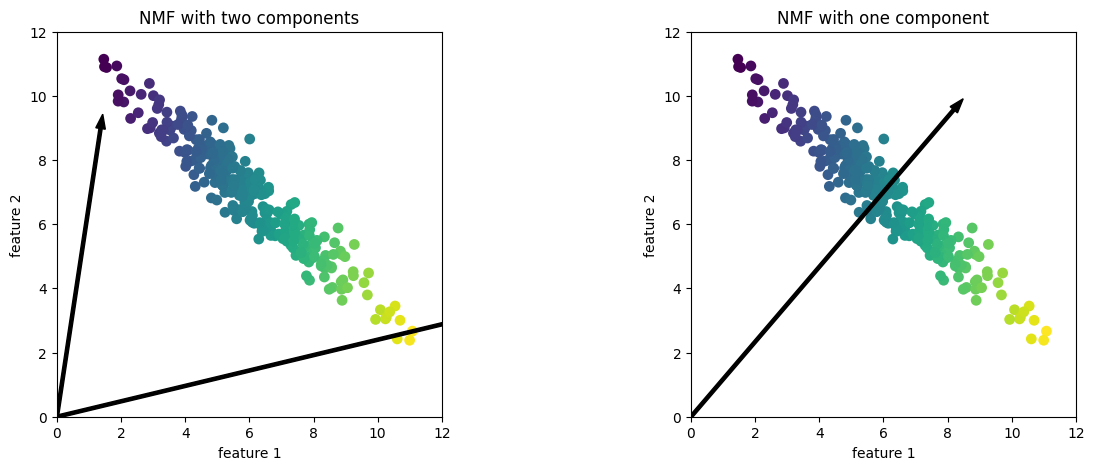

In [3]:
mglearn.plots.plot_nmf_illustration()

For NMF with two components, as shown on the left, it is clear that all points in the data can be written as a positive combination of the two components. If there are enough components to perfectly reconstruct the data (as many components as there are features), the algorithm will choose directions that point toward the extremes of the data.

Otherwise, if we only use a single component, NMF creates a component that points toward the mean, as pointing there best explains the data. You can see that in contrast with PCA, reducing the number of components not only removes some directions, but creates an entirely different set of components! Components in NMF are also not ordered in any specific way, so there is no “first non-negative component”: all components play
an equal part.

NMF uses a random initialization, which might lead to different results depending on the random seed

#### Applying NMF to face images

Now, let’s apply NMF to the Labeled Faces in the Wild dataset we used earlier. The main parameter of NMF is how many components we want to extract. Usually this is lower than the number of input features (otherwise, the data could be explained by making each pixel a separate component).

Let's try extracting 15 components

c:\Users\My computer\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


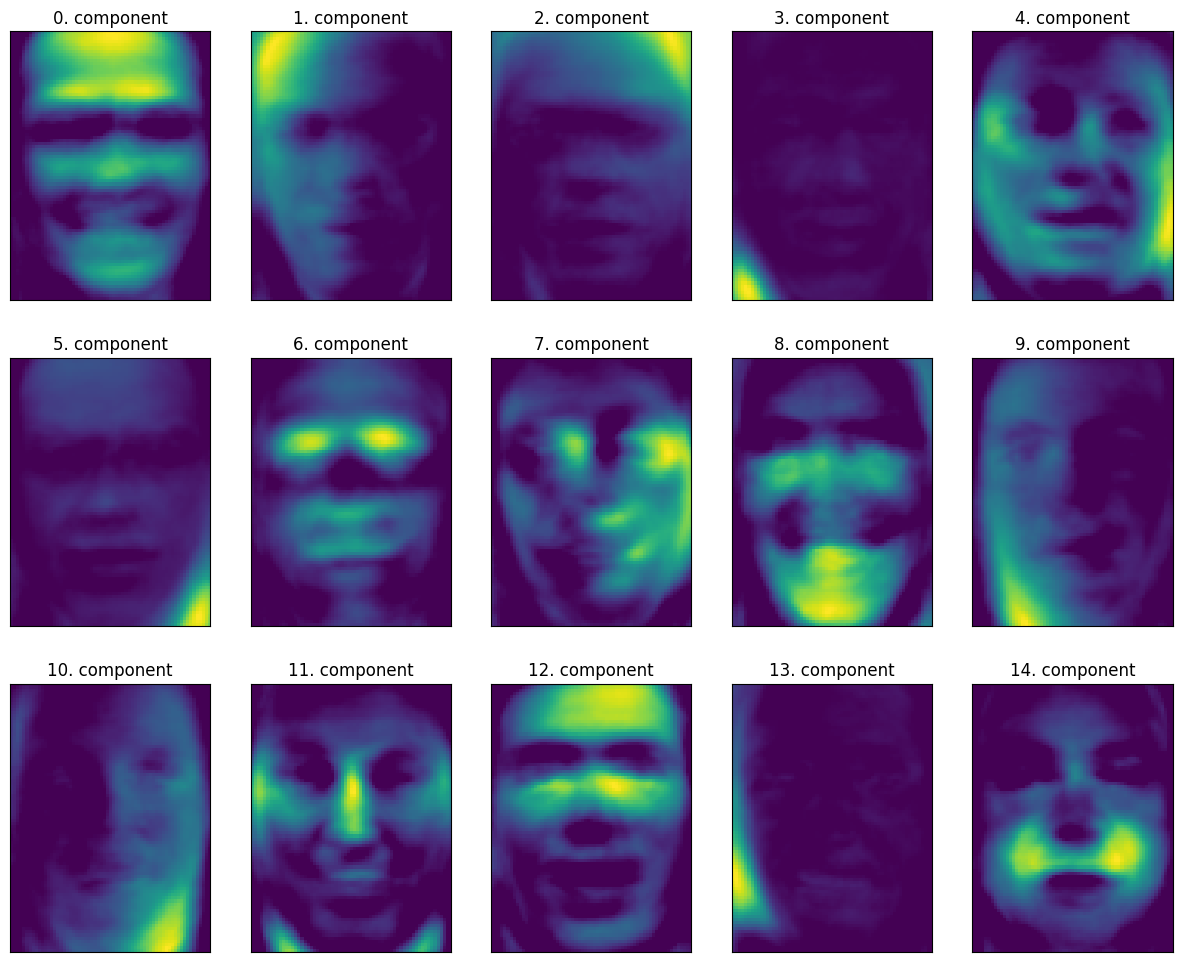

In [6]:
nmf = NMF(n_components = 15, random_state=0)
nmf.fit(X_train)
X_train_nmf = nmf.transform(X_train)
X_test_nmf = nmf.transform(X_test)
fix, axes = plt.subplots(3, 5, figsize = (15, 12),
subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(nmf.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape))
    ax.set_title("{}. component".format(i))

These components are all positive, and so resemble prototypes of faces much more than the components extracted by PCA.

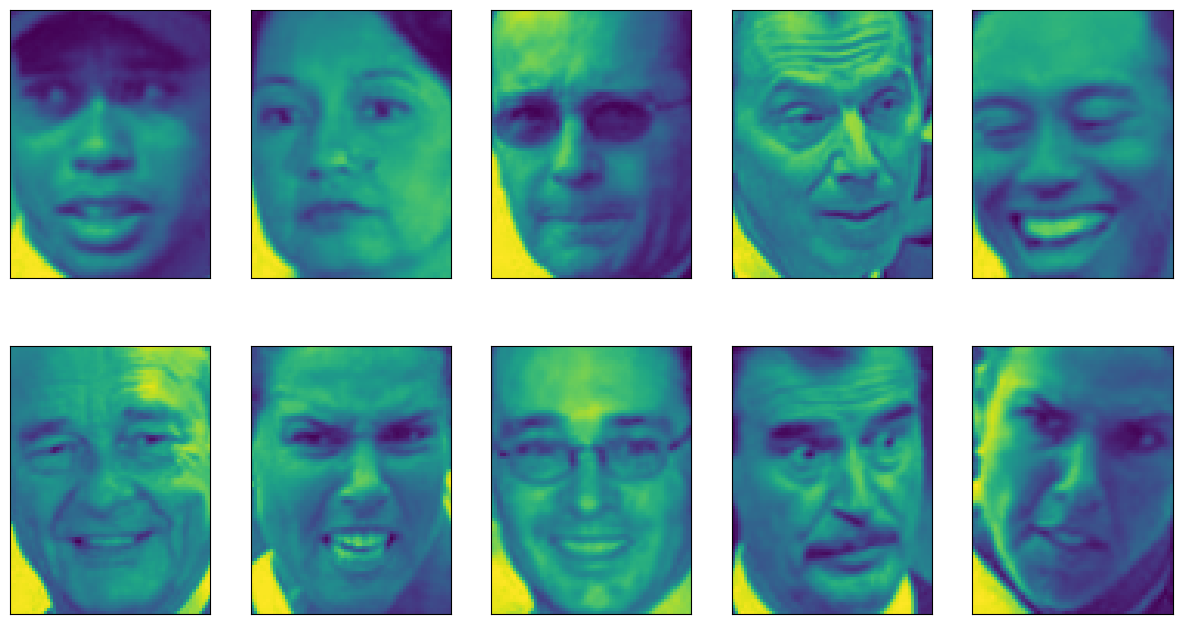

In [ ]:
compn = 3
# sort by 3rd component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

As expected, faces that have a high coefficient for component 3 are faces looking to
the right 

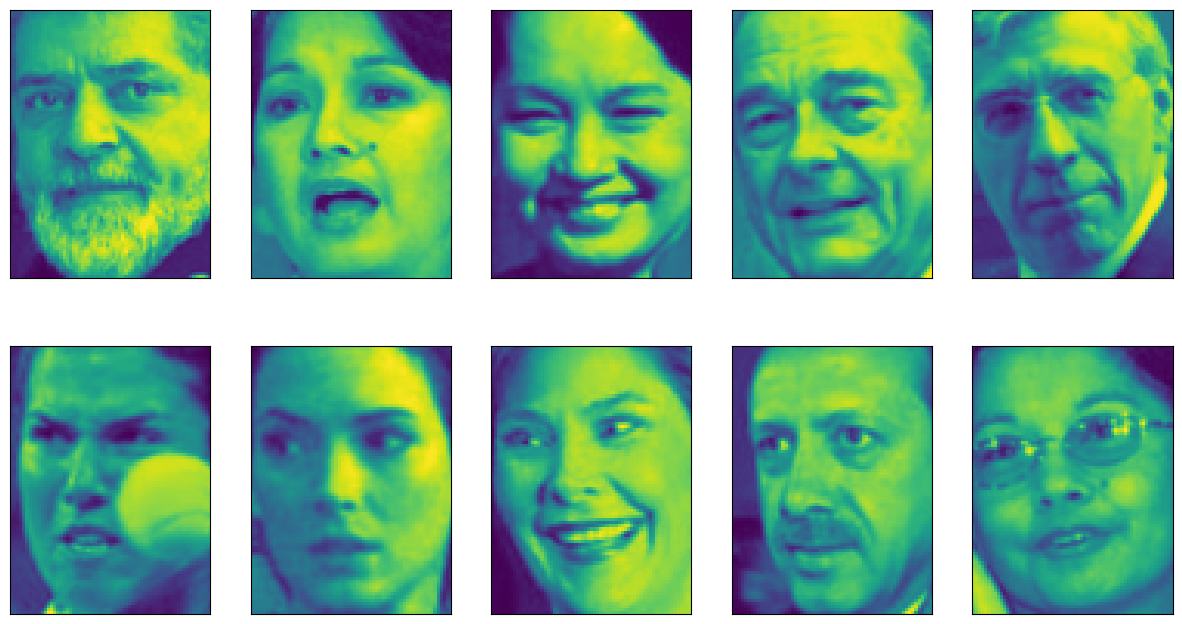

In [7]:
compn = 7
# sort by 7th component, plot first 10 images
inds = np.argsort(X_train_nmf[:, compn])[::-1]
fig, axes = plt.subplots(2, 5, figsize=(15, 8),
subplot_kw={'xticks': (), 'yticks': ()})
for i, (ind, ax) in enumerate(zip(inds, axes.ravel())):
    ax.imshow(X_train[ind].reshape(image_shape))

Faces with a high coefficient for component 7 are looking to the left

Extracting patterns like these works best for data with additive structure, including audio, gene expression, and text data.
Let’s walk through one example on synthetic data to see what this might look like.

Text(0, 0.5, 'Signal')

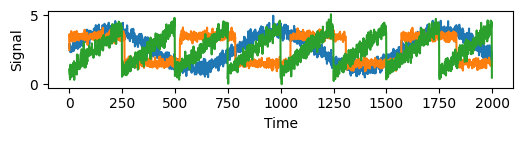

In [9]:
S = mglearn.datasets.make_signals()
plt.figure(figsize=(6, 1))
plt.plot(S, '-')
plt.xlabel("Time")
plt.ylabel("Signal")

Unfortunately we cannot observe the original signals, but only an additive mixture of
all three of them. We want to recover the decomposition of the mixed signal into the
original components. We assume that we have many different ways to observe the
mixture (say 100 measurement devices), each of which provides us with a series of
measurements:

In [10]:
# mix data into a 100-dimensional state
A = np.random.RandomState(0).uniform(size=(100, 3))
X = np.dot(S, A.T)
print("Shape of measurements: {}".format(X.shape))

Shape of measurements: (2000, 100)


We can use NMF to recover the three signals:

In [ ]:
nmf = NMF(n_components=3, random_state=42)
S_ = nmf.fit_transform(X)
print("Recovered signal shape: {}".format(S_.shape))

Recovered signal shape: (2000, 3)


In [ ]:
pca = PCA(n_components=3)
H = pca.fit_transform(X)

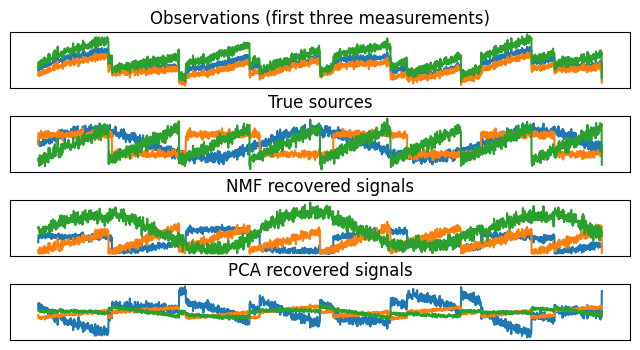

In [ ]:
models = [X, S, S_, H]
names = ['Observations (first three measurements)',
'True sources',
'NMF recovered signals',
'PCA recovered signals']
fig, axes = plt.subplots(4, figsize=(8, 4), gridspec_kw={'hspace': .5},
subplot_kw={'xticks': (), 'yticks': ()})
for model, name, ax in zip(models, names, axes):
    ax.set_title(name)
    ax.plot(model[:, :3], '-')

The figure includes 3 of the 100 measurements from X for reference. As you can see, NMF did a reasonable job of discovering the original sources, while PCA failed and used the first component to explain the majority of the variation in the data

There are many other algorithms that can be used to decompose each data point into a weighted sum of a fixed set of components, as PCA and NMF do. If interested, you can look into ndependent component analysis (ICA), factor analysis (FA), and sparse coding (dictionary learning), which is another popular technique for this kind of decomposition.